# SVM

Neste lab iremos implementar uma versão do SVM com solução via pseudoinversa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# magic para definer resolução como retina
%config InlineBackend.figure_format = 'retina'

## Exemplo da aula

Primeiro iremos reproduzir o exemplo da aula, com o seguinte dataset

|$x_1$|$x_2$|$y$|
| --- | --- | --- |
|3|3|$\circ$|
|2|3|$\circ$|
|2|1|$\square$|
|1|1|$\square$|

e seguindo a convenção $\circ = 1$ e $\square = -1$.

In [2]:
# Vetores coluna
v1 = np.array([[3,3]]).T
v2 = np.array([[2,3]]).T
v3 = np.array([[2,1]]).T
v4 = np.array([[1,1]]).T
n = 4

rhs = np.array([[1,1,-1,-1]]).T

In [3]:
# Para facilitar, iremos agrupar todos os vetores em uma matriz
M = np.hstack((v1, v2, v3, v4))

# adição do offset
M = np.vstack( (M, np.ones((1,n))) )
M

array([[3., 2., 2., 1.],
       [3., 3., 1., 1.],
       [1., 1., 1., 1.]])

In [4]:
# Agora, calculamos todos os produtos internos
P = M.T @ M
P

array([[19., 16., 10.,  7.],
       [16., 14.,  8.,  6.],
       [10.,  8.,  6.,  4.],
       [ 7.,  6.,  4.,  3.]])

Calculados dos produtos internos $P$, podemos resolver o sistema para encontrar a normal $w$

$$P x = rhs$$

In [5]:
# encontra a combinação que define w
x = np.round(np.linalg.pinv(P) @ rhs, 2)
x

array([[ 1.5],
       [-0. ],
       [-1. ],
       [-2.5]])

In [6]:
# calcular w
w = M @ x
w

array([[ 0.],
       [ 1.],
       [-2.]])

In [7]:
# função de predição
predicao = lambda x : w.T @ x

In [8]:
# testando a predição
predicao( M ).flatten(), rhs.flatten()

(array([ 1.,  1., -1., -1.]), array([ 1,  1, -1, -1]))

## Heart Disease

Base de dados sobre doenças cardíacas da UCI Irvine Machine Learning Repository. No [site](https://archive.ics.uci.edu/dataset/45/heart+disease) é possível ver a descrição da base, comentários e o desempenho dos modelos.

O objetivo é prever a última coluna "present" que indica se possui a doença.

In [9]:
db = pd.read_csv("heart.csv")
db.present = db.present.replace(0,-1)

# 80% dos dados serão utilizados para treino
n_training = int(db.shape[0] * 0.8)

# o ideal é amostrar os dados e não pegar os primeiros 80% como abaixo
training = db.loc[:n_training]
test = db.loc[n_training:]

In [10]:
# colunas com as features e a classe
db.columns.values

array(['id', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'present'],
      dtype=object)

<Axes: xlabel='chol', ylabel='age'>

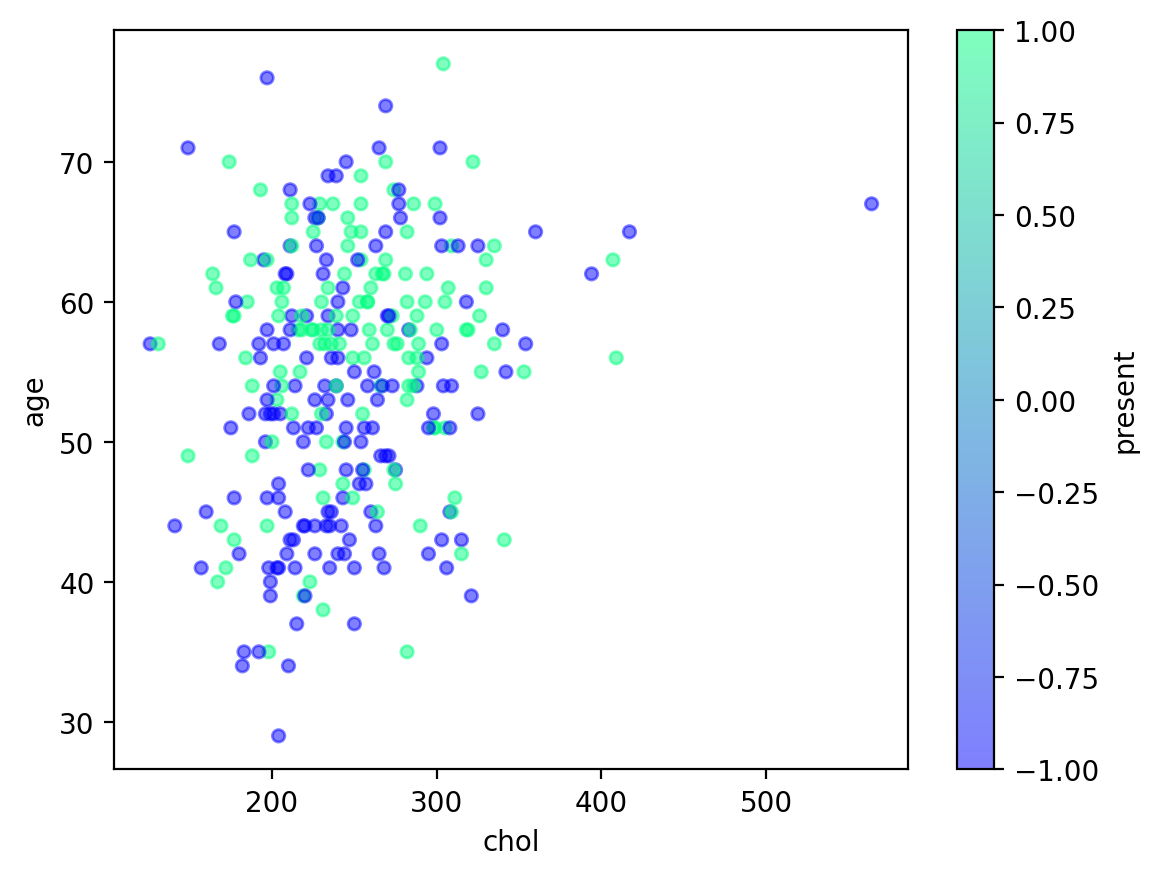

In [11]:
# plota chol contra age, com cores em present para verificar a separabilidade
db.plot.scatter(x="chol", y="age", c="present", colormap="winter", alpha=0.5)

In [12]:
def ret_desvios(dataset):
  # dataframe com apenas as features 1:-1
  F = dataset.iloc[:, 1:-1]
  rhs = dataset.present

  # É importante normalizar os dados antes de aplicar SVM, para deixarmos todos os dados na mesma escala
  D = F - F.mean()
  M = D / D.std()
  return M

M = ret_desvios( training )
M.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.970318,0.683494,-2.273946,0.728495,-0.349547,2.363797,0.91535,-0.042288,-0.723486,1.055135,2.232614,-0.708647,0.644749
1,1.415924,0.683494,0.878671,1.550730,0.661271,-0.421271,0.91535,-1.904434,1.376389,0.369945,0.636932,2.395487,-0.889754
2,1.415924,0.683494,0.878671,-0.641896,-0.425836,-0.421271,0.91535,-0.973361,1.376389,1.312081,0.636932,1.360776,1.156250


In [13]:
# Calculamos todos os produtos internos
P = M @ M.T
# encontra a combinação que define w
x = np.linalg.pinv(P) @ training.present
# calcula w
w = M.T @ x
w

age        -0.004173
sex         0.145578
cp          0.212376
trestbps    0.076256
chol        0.046035
fbs        -0.081231
restecg     0.087120
thalach    -0.103753
exang       0.134511
oldpeak     0.088224
slope       0.078131
ca          0.233938
thal        0.227260
dtype: float64

In [14]:
# função de predição
predicao = lambda x : (w.T @ x) >= 0

# funções de avaliação
acuracia = lambda predicao, rhs : np.sum(predicao == rhs) / len(rhs)
precisao = lambda predicao, rhs : np.sum(predicao[rhs == 1] == rhs[rhs == 1]) / np.sum(predicao == 1)

Agora iremos realizar a predição para o conjunto de treino e depois para o conjunto de teste

In [15]:
# aplicar predicao
pred = predicao(M.T).astype(int) * 2 - 1

# erros
acuracia(pred, training.present), precisao(pred, training.present)

(0.8571428571428571, 0.839622641509434)

In [16]:
# verificar dados de teste
M_t = ret_desvios( test )
pred = predicao(M_t.T).astype(int) * 2 - 1

# erros
acuracia(pred, test.present), precisao(pred, test.present)

(0.8, 0.8518518518518519)

## Utilizando SVC

Podemos utilizar a implementação do support vector classifier do sklearn, que facilita todo este processo

In [17]:
from sklearn.svm import SVC

In [18]:
# modelo com kernel linear
model = SVC(kernel="linear")
model.fit(M, training.present)

# predição
pred = model.predict(M)

# erros
acuracia(pred, training.present), precisao(pred, training.present)

(0.8613445378151261, 0.8543689320388349)

In [19]:
# validação
pred = model.predict(M_t)

# erros
acuracia(pred, test.present), precisao(pred, test.present)

(0.8, 0.88)

## Com Kernel polinomial

In [20]:
# modelo com kernel linear
model = SVC(kernel="poly", degree=2)
model.fit(M, training.present)

# predição
pred = model.predict(M)

# erros
acuracia(pred, training.present), precisao(pred, training.present)

(0.7857142857142857, 0.9104477611940298)

In [21]:
# validação
pred = model.predict(M_t)

# erros
acuracia(pred, test.present), precisao(pred, test.present)

(0.6833333333333333, 0.875)

## Com Kernel RBF

In [22]:
# modelo com kernel linear
model = SVC(kernel="rbf")
model.fit(M, training.present)

# predição
pred = model.predict(M)

# erros
acuracia(pred, training.present), precisao(pred, training.present)

(0.9243697478991597, 0.94)

In [23]:
# validação
pred = model.predict(M_t)

# erros
acuracia(pred, test.present), precisao(pred, test.present)

(0.7666666666666667, 0.84)

## Com Kernel RBF e ajuste de soft margin

In [24]:
# modelo com kernel linear
model = SVC(kernel="rbf", C=10) # verifique a doc para ajustar C
model.fit(M, training.present)

# predição
pred = model.predict(M)

# erros
acuracia(pred, training.present), precisao(pred, training.present)

(0.9915966386554622, 1.0)

In [25]:
# validação
pred = model.predict(M_t)

# erros
acuracia(pred, test.present), precisao(pred, test.present)

(0.8, 0.8518518518518519)